<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Monocle-analysis-of-cell-gene-matrix" data-toc-modified-id="Monocle-analysis-of-cell-gene-matrix-1">Monocle analysis of cell-gene matrix</a></span><ul class="toc-item"><li><span><a href="#Setup-for-analysis" data-toc-modified-id="Setup-for-analysis-1.1">Setup for analysis</a></span><ul class="toc-item"><li><span><a href="#Load-/-install-packages" data-toc-modified-id="Load-/-install-packages-1.1.1">Load / install packages</a></span></li><li><span><a href="#Notebook-wide-variables-/-functions" data-toc-modified-id="Notebook-wide-variables-/-functions-1.1.2">Notebook-wide variables / functions</a></span></li></ul></li><li><span><a href="#Get-cell-gene-matrices" data-toc-modified-id="Get-cell-gene-matrices-1.2">Get cell-gene matrices</a></span><ul class="toc-item"><li><span><a href="#Specify-cell-types" data-toc-modified-id="Specify-cell-types-1.2.1">Specify cell types</a></span></li><li><span><a href="#Specify-samples" data-toc-modified-id="Specify-samples-1.2.2">Specify samples</a></span></li><li><span><a href="#Load-cell-gene-matrix" data-toc-modified-id="Load-cell-gene-matrix-1.2.3">Load cell-gene matrix</a></span></li></ul></li><li><span><a href="#Estimate-multiplet-frequency" data-toc-modified-id="Estimate-multiplet-frequency-1.3">Estimate multiplet frequency</a></span><ul class="toc-item"><li><span><a href="#Annotate-cross-celltype-multiplets" data-toc-modified-id="Annotate-cross-celltype-multiplets-1.3.1">Annotate cross-celltype multiplets</a></span></li><li><span><a href="#Tabulate-multiplet-frequency" data-toc-modified-id="Tabulate-multiplet-frequency-1.3.2">Tabulate multiplet frequency</a></span></li></ul></li><li><span><a href="#Filter-low-quality-cells" data-toc-modified-id="Filter-low-quality-cells-1.4">Filter low-quality cells</a></span><ul class="toc-item"><li><span><a href="#Annotate-number-of-cellular-and-flu-mRNAs,-set-bounds-for-filtering" data-toc-modified-id="Annotate-number-of-cellular-and-flu-mRNAs,-set-bounds-for-filtering-1.4.1">Annotate number of cellular and flu mRNAs, set bounds for filtering</a></span></li><li><span><a href="#Plot-cellular-/-flu-mRNAs-with-filters" data-toc-modified-id="Plot-cellular-/-flu-mRNAs-with-filters-1.4.2">Plot cellular / flu mRNAs with filters</a></span></li></ul></li><li><span><a href="#Estimate-infected-thresholds-from-canine-cells" data-toc-modified-id="Estimate-infected-thresholds-from-canine-cells-1.5">Estimate infected thresholds from canine cells</a></span><ul class="toc-item"><li><span><a href="#Check-for-constant-fraction-flu" data-toc-modified-id="Check-for-constant-fraction-flu-1.5.1">Check for constant fraction flu</a></span></li><li><span><a href="#Confirm-equal-mix-of-flu-barcodes-in-canine-cells" data-toc-modified-id="Confirm-equal-mix-of-flu-barcodes-in-canine-cells-1.5.2">Confirm equal mix of flu barcodes in canine cells</a></span></li><li><span><a href="#Look-at-segment-frequencies" data-toc-modified-id="Look-at-segment-frequencies-1.5.3">Look at segment frequencies</a></span></li></ul></li></ul></li></ul></div>

# Monocle analysis of cell-gene matrix
This notebook starts with the annotated cell-gene matrix, and performs analyses using [Monocle](http://cole-trapnell-lab.github.io/monocle-release/).

Analysis by Alistair Russell and [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

## Setup for analysis

### Load / install packages
Load or install the necessary `R` packages, print session information that describes the packages / versions used.

In [1]:
options(warn=-1) # suppress warnings that otherwise clutter output

if (!require("pacman", quietly=TRUE)) 
  install.packages("pacman")
pacman::p_load("ggplot2", "ggthemes", "ggExtra", "gridExtra", "cowplot", "scales", "reshape2", 
  "dplyr", "magrittr", "rmarkdown", "IRdisplay", "psych", "qlcMatrix", "colorRamps", "ggpubr",
  "tidyverse", "RColorBrewer", "naturalsort", "grid", "DescTools")

bioc.packages <- c("monocle", "piano")
if (!(all(suppressMessages(lapply(bioc.packages, require, quietly=TRUE, character.only=TRUE))))) {
  source("http://bioconductor.org/biocLite.R")
  biocLite()
  biocLite(bioc.packages, suppressWarnings=TRUE)
}   
    
# print information on session
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   stats4    parallel  grid      stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] piano_1.16.1        monocle_2.5.3       DDRTree_0.1.5      
 [4] irlba_2.2.1         VGAM_1.0-3          Biobase_2.36.2     
 [7] BiocGenerics_0.22.0 DescTools_0.99.23   naturalsort_0.1.3  
[10] RColorBrewer_1.1-2  purrr_0.2.2.2       readr_1.1.1        
[13] tidyr_0.6.3         tibble_1.3.3        tidyverse_1.1.1    
[16] ggpubr_0.1.4        colorRamps_2.3      qlcMatrix_0.9.5    
[19] slam_0.1-40         Matrix_1.2-12       psych_1.7.5      

### Notebook-wide variables / functions
Define some variables and functions that are used throughout the rest of the notebook.

In [2]:
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
# The palette with grey:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
               "#0072B2", "#D55E00", "#CC79A7")
# The palette with black
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                "#0072B2", "#D55E00", "#CC79A7")

# plots will be saved here
plotsdir <- './results/plots/'
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir)    
    
# figures for paper will be saved here
figsdir <- './paper/figures/'
if (!dir.exists(figsdir))
  dir.create(figsdir)

saveShowPlot <- function(p, width, height, isfig=FALSE) {
  # save plot with filename of variable name with dots replaced by _, then show
  # if *isfig* is TRUE, then also saves a PDF to *figsdir*
  pngfile <- file.path(plotsdir, sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  figfile <- file.path(figsdir, sprintf("%s.pdf", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  if (isfig)
    ggsave(figfile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

## Get cell-gene matrices

### Specify cell types

We have two cell types in the experiments, and there is a separate cell-gene matrix for each cell type.
The two cell types are:
  - *humanplusflu*: A549 cells infected with influenza
  - *canine*: MDCK cells spiked in as a control to estimate leakage / contamination rate.

For most analyses, the *humanplusflu* cell types is the one of interest, the *canine* cells are the "other" cell type used as a control.
We therefore specify variables giving the celltype of interest and the other cell type:

In [3]:
celltype_interest <- "humanplusflu"
celltype_other <- "canine"

celltypes <- c(celltype_interest, celltype_other)

### Specify samples
We have two samples:
  - *IFN_enriched*: cells that have been MACS-sorted for IFN+ at 13-hours post-infection
  - *not_enriched*: cells at 10 hours post-infection that have not been sorted for IFN+

In [4]:
samples <- c("IFN_enriched", "not_enriched")

### Load cell-gene matrix

We load the cell-gene matrices that were created previously by [align_and_annotate.ipynb](align_and_annotate.ipynb).
These matrices include all cells identified by [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger).
Note that the flu reads are annotated by the synonymous barcodes near the 3' ends by [align_and_annotate.ipynb](align_and_annotate.ipynb) after the [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) analysis

Note that each cell-gene matrix has entries for all samples.

In [5]:
# Cell gene matrices in this directory
matrixdir <- "./results/cellgenecounts/"

# Read cell-gene matrices for each sample into a vector named by cell type.
# These are in `matrixdir` with names like "merged_humanplusflu_matrix.mtx"
all_cells <- lapply(
  setNames(celltypes, celltypes),
  function(celltype) {
    newCellDataSet(
      readMM(file.path(matrixdir, paste("merged", celltype, "matrix.mtx", sep="_"))),
      phenoData=new(
        "AnnotatedDataFrame",
        data=read.delim(file.path(matrixdir, paste("merged", celltype, "cells.tsv", sep="_")))
        ),
      featureData=new(
        "AnnotatedDataFrame",
        data=read.delim(file.path(matrixdir, paste("merged", celltype, "genes.tsv", sep="_")))
        ),
      expressionFamily=negbinomial.size()
      ) 
    }
  )

Here are some basic statistics about the number of cells in the matrix for each cell type and Sample.
We see below that most of the cells are *humanplusflu*. 
This is expected, since the canine cells were spiked in at a relatively low fraction (targeting about 5 to 10%).

Sample,celltype,ncells
IFN_enriched,humanplusflu,1626
IFN_enriched,canine,62
not_enriched,humanplusflu,1634
not_enriched,canine,115


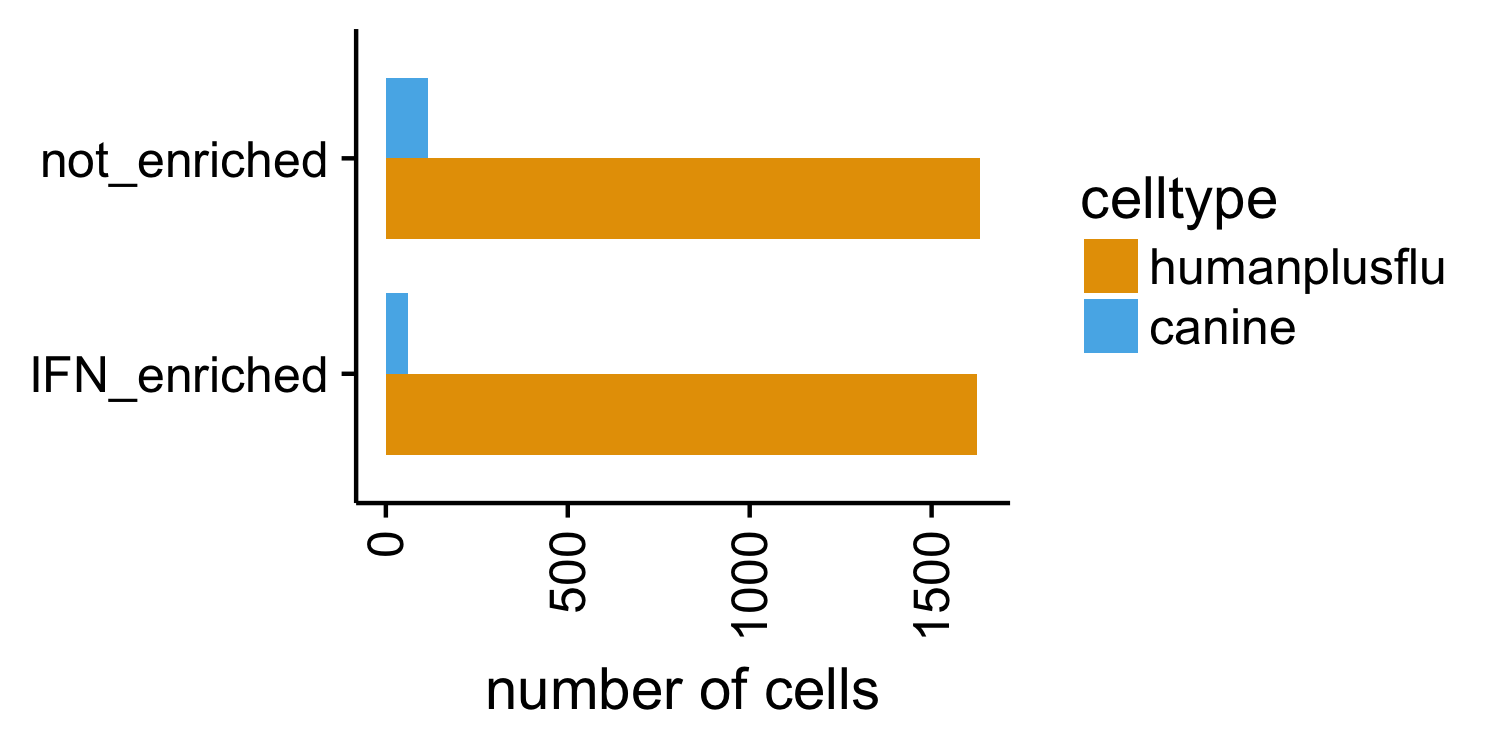

In [6]:
# get and show number of cells for each sample and celltype
tab_ncells_nofilter <- lapply(
    celltypes,
    function (celltype) {pData(all_cells[[celltype]]) %>% mutate(celltype=celltype)}
    ) %>%
  bind_rows %>%
  transform(Sample=factor(Sample, samples), celltype=factor(celltype, celltypes)) %>%
  arrange(Sample, celltype) %>%
  group_by(Sample, celltype) %>%
  summarize(ncells=n())

tab_ncells_nofilter

# plot number of cells
p_ncells_nofilter <- ggplot(tab_ncells_nofilter,
    aes(Sample, y=ncells, x=Sample, fill=celltype)) +
  geom_bar(width=0.75, position="dodge", stat="identity") +
  scale_y_continuous(name="number of cells") +
  scale_x_discrete(name=NULL) + 
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
  coord_flip() +
  scale_fill_manual(values=tail(cbbPalette, -1))

saveShowPlot(p_ncells_nofilter, width=5, height=2.5)

Note that the statistics above are for the cells called by the 10X [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) pipeline with **no filtering** of multiplets and outlier cells.
These statistics change as we do the filtering below...

## Estimate multiplet frequency
We determine the "multiplet rate": the rate at which a droplet with a cell actually contains multiple cells.
We do this by looking at the rate of cross-celltype multiplets, where we identify the same cell barcode on *humanplusflu* and *canine* cells.

### Annotate cross-celltype multiplets
We first look for cell barcodes that are called as both *humanplusflu* and *canine* cells.
There are cross-species multiplets, and should be filtered from downstream analyses.
Their identification also provides an estimate of the rate of multiplets in each sample overall.

We annotate whether a cell is human / canine by adding a new *pData* attribute called *cross_celltype_multiplet*.

In [7]:
# Annotate cross-celltype multiplets
for (celltype in celltypes) {
  # get all barcodes for the other cell type  
  other_cellbarcodes <- lapply(
      celltypes,
      function (other_celltype) {
        if (celltype != other_celltype) { 
          pData(all_cells[[other_celltype]])$CellBarcode %>% as.character
        }
      }
      ) %>%
    unlist 
  # mark shared barcodes as multiplets  
  pData(all_cells[[celltype]])$cross_celltype_multiplet <- all_cells[[celltype]] %>%
    pData %$% 
    CellBarcode %in% other_cellbarcodes
}

Here are the statistics on these cross-celltype multiplets:

In [8]:
tab_cross_celltype_multiplets <- lapply(
    celltypes,
    function (celltype) {
      all_cells[[celltype]] %>% 
      pData %>% 
      mutate(celltype=celltype) %>%
      group_by(Sample, celltype, cross_celltype_multiplet) %>% 
      summarize(ncells=n()) %>%
      ungroup
    }) %>%
  bind_rows %>%
  as_tibble %>%
  arrange(Sample)

tab_cross_celltype_multiplets

Sample,celltype,cross_celltype_multiplet,ncells
IFN_enriched,humanplusflu,FALSE,1614
IFN_enriched,humanplusflu,TRUE,12
IFN_enriched,canine,FALSE,50
IFN_enriched,canine,TRUE,12
not_enriched,humanplusflu,FALSE,1610
not_enriched,humanplusflu,TRUE,24
not_enriched,canine,FALSE,91
not_enriched,canine,TRUE,24


### Tabulate multiplet frequency
Now we put this data in a form that is easier to handle and visualize, and estimate the multiplet frequency. 
We estimate the multiplet frequency from the number of *canine* cells, *humanplusflu* cells, and multiplets using the function described in [Bloom (2018, DOI 10.1101/293639)](https://doi.org/10.1101/293639).

In [9]:
# function from:
# https://github.com/jbloomlab/multiplet_freq/blob/master/calcmultiplet.ipynb
# Note that for this function, n1 and n2 are droplets with any cells from that
# host (including doublets).
multiplet_freq <- function(n1, n2, n12) {
  n <- n1 * n2 / n12
  mu1 <- -log((n - n1) / n)
  mu2 <- -log((n - n2) / n)
  mu <- mu1 + mu2
  return (1 - mu * exp(-mu) / (1 - exp(-mu)))
}

# get number of multiplets for each sample
n_multiplets <- tab_cross_celltype_multiplets %>%
  filter(cross_celltype_multiplet) %>%
  group_by(Sample) %>%
  summarise(multiplets=mean(ncells)) 

# get single wide tibble with counts
counts_celltypes_multiplets <- tab_cross_celltype_multiplets %>%
  spread(celltype, ncells) %>%
  filter(! cross_celltype_multiplet) %>%
  select(-cross_celltype_multiplet) %>%
  merge(n_multiplets) %>%
  mutate(total_droplets=rowSums(.[2:4]),
         multiplet_freq=multiplet_freq(humanplusflu + multiplets,
                                       canine + multiplets,
                                       multiplets))

# display tibble
counts_celltypes_multiplets 

Sample,canine,humanplusflu,multiplets,total_droplets,multiplet_freq
IFN_enriched,50,1614,12,1676,0.1071366
not_enriched,91,1610,24,1725,0.1192787


So we see from the above analysis that only $\sim$10% of the droplets are multiplets.

## Filter low-quality cells
In the previous section, we estimated the multiplet frequency in the data returned by the `cellranger` pipeline.

However, we can also try to filter the multiplets and other low-quality cells. We do this in two ways:

 1. We can immediately remove any of the cross-celltype multiplets, as those are obviously multiplets.
 2. We remove cells that have substantially more or less than the median number of cellular mRNAs detected for that cell type. This procedure is recommended in the [Monocle documentation](http://cole-trapnell-lab.github.io/monocle-release/docs/), and will remove multiplets since they will often have lots of mRNA detected, as well as some low-quality cells with little mRNA detected.


### Annotate number of cellular and flu mRNAs, set bounds for filtering
First we annotate cells with the number of total mRNAs, cellular mRNAs, total flu mRNAs, flu mRNAs for each gene, and fraction of total mRNA from flu.
Note that for the *canine* cells, the flu genes are **not** in the reference genome, as the canine cells weren't infected. Nonetheless, they will have a small fraction of flu reads due to leakage. 
We get their number of flu reads from the pre-annotation of the cell-gene matrix.
For the *humanplusflu* cells, we calculate the flu reads from the cell-gene matrix.

In [ ]:
# names of the flu genes
# use "flu" prefix so "NA" isn't interpreted as not any
flugenes <- c("fluPB2", "fluPB1", "fluPA", "fluHA",
               "fluNP", "fluNA", "fluM", "fluNS")
flugenes_noprefix <- sapply(flugenes, function (x) gsub("flu", "", x))

# annotate by number of total, cellular, and flu mRNAs, and frac from flu
all_cells <- lapply(
  all_cells,
  function (c) {
    pData(c)$total_mRNAs <- Matrix::colSums(exprs(c))
      
    pData(c)$cell_mRNAs <- Matrix::colSums(exprs(c[
      row.names(subset(fData(c), !(gene_short_name %in% flugenes))),]))
      
    flu_indices <- subset(fData(c), (gene_short_name %in% flugenes))
    if (nrow(flu_indices) == length(flugenes)) {
      # flu genes in cell-gene matrix, so calculate flu mRNAs from that
      pData(c)$flu_mRNAs <- Matrix::colSums(exprs(c[
        row.names(flu_indices),]))
      for (g in flugenes) {
        pData(c)[[paste0(g, "_mRNAs")]] = Matrix::colSums(
          exprs(c[row.names(subset(fData(c), gene_short_name == g)), ]))    
      }
    } else {
      # use flu count set during custom annotation of cell-gene matrix
      pData(c)$flu_mRNAs <- pData(c)$total_annotated_flu
      for (g in flugenes) {
        pData(c)[[paste0(g, "_mRNAs")]] = pData(c)[[
          paste0("annotated_", g)]]
      }
    }

    pData(c)$frac_mRNA_from_flu <- pData(c)$flu_mRNAs / pData(c)$total_mRNAs

    return(c)
  }
  )

Now we compute the median number of cellular mRNAs for each sample and exclude cells with substantially more or less than this median by setting upper and lower bounds.
We set a *filtered* flag for all cells outside these bounds, as well as for any cells that are cross-celltype doublets:

In [ ]:
bottom_bound = 2 # exclude if this many fold less than median
top_bound = 2 # exclude if this many fold more than median

# annotate cells with bounds
all_cells <- lapply(
  all_cells,
  function (c) {
    pData(c)$median_cell_mRNAs <- c %>%
      pData %>%
      group_by(Sample) %>%
      mutate(median=median(cell_mRNAs)) %>%
      ungroup %>%
      select(median) %>%
      unlist
    pData(c)$lower_bound_cell_mRNAs <- pData(c)$median_cell_mRNAs / bottom_bound
    pData(c)$upper_bound_cell_mRNAs <- pData(c)$median_cell_mRNAs * top_bound
    pData(c)$filtered <- (
      pData(c)$cell_mRNAs < pData(c)$lower_bound_cell_mRNAs |
      pData(c)$cell_mRNAs > pData(c)$upper_bound_cell_mRNAs |
      pData(c)$cross_celltype_multiplet)
    return(c)
    }
    )

# print the bounds and number of filtered cells
lapply(
  all_cells,
  function (c) {
    pData(c) %>% 
      group_by(Sample) %>%
      summarize(median_cell_mRNAs=median_cell_mRNAs %>% first,
                lower_bound_cell_mRNAs=lower_bound_cell_mRNAs %>% first,
                upper_bound_cell_mRNAs=upper_bound_cell_mRNAs %>% first,
                n_retained=sum(! filtered),
                n_filtered=sum(filtered))
  }
  ) %>%
  bind_rows(.id="cell_type")

### Plot cellular / flu mRNAs with filters
Now we plot the number of cellular and viral mRNAs and show the filtering.
Each point is a cell, the blue lines show the density over number of cellular mRNAs per cell, the green dotted lines show the lower and upper bounds for filtering, and the orange rug plots show the distribution of the number of flu mRNAs per cell.
This plot does **not** show the cross-celltype multiplets, which are excluded from plotting since they have been filtered by another method already.

In [ ]:
# combine data for cell types to plot
mRNA_counts_data <- all_cells %>%
  lapply(function (c) {pData(c)}) %>%
  bind_rows(.id="cell_type") %>%
  transform(Sample=factor(Sample, levels=samples),
            cell_type=factor(cell_type, levels=celltypes)) %>%
  filter(! cross_celltype_multiplet)

# create scatter plot
scatterplot <- ggplot(mRNA_counts_data,
    aes(cell_mRNAs, flu_mRNAs), color=cbbPalette[[1]]) +
  geom_point(alpha=0.4) + 
  geom_rug(sides='l', alpha=0.2, color=cbbPalette[[2]], size=0.8)

# density plot, get value of maxy as here: https://stackoverflow.com/a/10659563
densityplot <- eval(substitute(
  {stat_density(aes(x=cell_mRNAs, y=maxy*(..scaled..)), geom="line", color=cbbPalette[[3]])},
  list(maxy=layer_scales(scatterplot)$y$range$range[2])))

# combine into faceted plot
p_flu_vs_cell <- scatterplot + densityplot + 
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +  
  geom_vline(aes(xintercept=lower_bound_cell_mRNAs), 
                 color=cbbPalette[[4]], linetype='dotted') +
  geom_vline(aes(xintercept=upper_bound_cell_mRNAs),
                 color=cbbPalette[[4]], linetype='dotted') +
  facet_grid(Sample ~ cell_type, scales='free_x') + 
  xlab("cellular mRNAs per cell") + 
  ylab("flu mRNAs per cell") 

saveShowPlot(p_flu_vs_cell, width=6.5, height=4.5)

A key point in the above filtering is that we filtered based on the number of **cellular** mRNAs rather than total mRNAs.
Our approach makes sense if the flu RNAs are extra in additional to the cellular mRNAs, but less sense if they replace the cellular mRNAs so that the total mRNA of infected cells is similar to uninfected cells.
In the latter case, filtering out low cellular mRNA cells would preferentially remove infected cells.

In our prior work ([Russell et al (2018)](https://elifesciences.org/articles/32303)), it seemed that viral mRNAs were mostly additional to cellular ones, supporting the idea of filtering on cellular mRNAs. 
To confirm that it is also the case here, we correlate the fraction of mRNA from flu with total and cellular mRNA.
We see that for the infected cells (*humanplusflu*), it is much more correlated with total mRNA, with infected cells (lots of mRNA from flu) tending to have more total mRNA. 
Therefore, it makes more sense to filter on cellular mRNA as we have done above since it appears that highly infected cells tend to have similar amounts of cellular mRNA but more total mRNA.

In [ ]:
# creates string of correlation (R and P-value)
cor_string <- function (x1, x2) {
  cor <- cor.test(x1, x2, method='pearson')
  sprintf("R = %.2f (P = %.1g)", cor$estimate, cor$p.value)
}

mRNA_counts_data %>%
  group_by(Sample, cell_type) %>%
  summarize(fracflu_vs_total_mRNA=cor_string(
              frac_mRNA_from_flu, total_mRNAs),
            fracflu_vs_cellular_mRNA=cor_string(
              frac_mRNA_from_flu, cell_mRNAs))

## Estimate infected thresholds from canine cells
We want to determine which cells we think are truly infected with flu various versus just having flu mRNA they have picked up from lysed cells.
The canine cells provide a way to examine this, since they are **not** infected with flu and so should provide a baseline for how much viral mRNA to expect in non-infected cells.

### Check for constant fraction flu
The simplest scenario is one in which all non-infected cells simply acquire some fraction of their mRNA from flu.
In this case, we would expect the number of flu mRNAs per cell to scale linearly with the total number of mRNA.
First, we make some plots that suggest that this may be approximately true:

In [ ]:
threshold_data <- all_cells[[celltype_other]] %>%
  pData %>% 
  filter(! filtered) %>%
  rename_all(funs(stringr::str_replace(., "annotated_", ""))) 
         
p_threshold_linear <- ggplot(
    threshold_data, aes(total_mRNAs, flu_mRNAs)) +
  geom_point() +
  geom_smooth(method='lm') + 
  facet_wrap(~Sample, scales='free')

saveShowPlot(p_threshold_linear, width=6, height=3)

Next, we estimate the fraction of mRNA in these infected cells that comes from flu.
There are two ways we could do this:
  1. Simply averaging over all cells
  2. Taking a weighted average over cells, so that cells with more mRNA are weighted more strongly.
  
Below we see that these approaches given essentially identical results, so we just use the first approach.

In [ ]:
threshold_data %>% 
  group_by(Sample) %>%
  summarize(mean_frac_flu=mean(frac_mRNA_from_flu),
         weighted_mean_frac_flu=sum(flu_mRNAs) / sum(total_mRNAs))

We now annotate cells by the predicted number of mRNAs from flu if they just have the average fractions calculated above: 

In [ ]:
threshold_data <- threshold_data %>% 
  group_by(Sample) %>%
  mutate(mean_frac_flu=mean(frac_mRNA_from_flu)) %>%
  ungroup %>%
  mutate(predicted_flu_mRNAs=mean_frac_flu * total_mRNAs)

p_actual_predicted_flu <- ggplot(
    threshold_data, aes(predicted_flu_mRNAs, flu_mRNAs)) +
  geom_point() +
  facet_wrap(~Sample, scales='free') 

saveShowPlot(p_actual_predicted_flu, width=6, height=3)

We now test if the predictions fit as well as expected if the data really Poisson distributed from the generated values.
We do this using the [Poisson deviance goodness of fit test described here](http://thestatsgeek.com/2014/04/26/deviance-goodness-of-fit-test-for-poisson-regression/).
We find that for the *IFN_enriched* sample, we can reject the Poisson fit.
For the *not_enriched* sample, the idea of Poisson error around the estimated fraction provides a good fit.
Still, the predicted values are reasonably close, so we are going to use the idea of a fraction of flu contamination to define "infected cells."

In [ ]:
threshold_data %>%
  mutate(dev_term=flu_mRNAs * log(flu_mRNAs / predicted_flu_mRNAs) -
                  (flu_mRNAs - predicted_flu_mRNAs)) %>%
  group_by(Sample) %>%
  summarize(deviance=2 * sum(dev_term),
            ndegrees=n() - 1,
            P=pchisq(deviance, ndegrees, lower.tail=FALSE))

### Confirm equal mix of flu barcodes in canine cells
The human cells were infected with a mix of wildtype and synonymously barcoded virus.

If the *canine* cells are just picking up environmental viral mRNA, then each should have a mix of mRNAs from these two viruses that should match the average composition of the *humanplusflu* cells.

Below we verify that this is true: for both samples, we see that the fraction of flu reads with annotated wildtype or synonymous barcodes is about the same in *canine* and *humanplusflu* samples.
Therefore, for the rest of this section, we will just use the fraction estimated from the *canine* cells.

In [ ]:
lapply(all_cells, function (c) pData(c)) %>%
  bind_rows(.id="cell_type") %>%
  filter(! filtered) %>%
  group_by(Sample, cell_type) %>%
  summarize(n_wt_flu=sum(annotated_flu_wt),
            n_syn_flu=sum(annotated_flu_syn),
            frac_flu_wt=n_wt_flu / (n_wt_flu + n_syn_flu))

Now we examine how well the fraction of flu reads from each barcode actually follows the predicted value assuming equal mixing.
We obviously expect more statistical noise for samples with fewer reads with annotated barcodes, so we plot the fraction from each barcode as a function of the number of barcode-annotated reads.
In the plots below, the horizontal line indicates the expected fraction from the sample averages.
As the plot shows, the actual fractions are clustered around the horizontal line, with the clustering getting tighter as we increase the number of flu reads.
This is as expected.

In [ ]:
threshold_data <- threshold_data %>%
  group_by(Sample) %>%
  mutate(avg_frac_flu_wt=sum(flu_wt) /
          (sum(flu_wt) + sum(flu_syn))) %>%
  ungroup %>%
  mutate(n_annotated_flu=flu_wt + flu_syn,
         frac_flu_wt=flu_wt / n_annotated_flu,
         predicted_flu_wt=avg_frac_flu_wt * n_annotated_flu)

p_barcode_fraction <- ggplot(
    threshold_data, aes(n_annotated_flu, frac_flu_wt)) +
  geom_point(alpha=0.33) +
  geom_hline(aes(yintercept=avg_frac_flu_wt), color=cbbPalette[[2]]) + 
  facet_wrap(~Sample, scales='free_x')

saveShowPlot(p_barcode_fraction, width=6, height=3)

We now determine whether the observed "noise" in the fraction of flu with each barcode is consistent with a binomial distribution parameterized by the average fraction flu across the sample.
We do this using the binomial deviance goodness of fit test, [calculating the deviance using the formula provided here](http://data.princeton.edu/wws509/notes/a2.pdf).
As can be seen below, we cannot reject the null hypothesis of a binomial distribution, suggesting we can interprt the binomial as a good fit, and assume equal mixing of barcodes in the *canine* cells.

In [ ]:
threshold_data %>%
  filter(n_annotated_flu > 0) %>%
  mutate(dev_term1=ifelse(flu_wt == 0,
                          0,
                          flu_wt * log(flu_wt / predicted_flu_wt)),
         dev_term2=ifelse(flu_syn == 0,
                          0,
                          log(flu_syn / (n_annotated_flu - 
                                         predicted_flu_wt))),
         dev_term=dev_term1 + dev_term2) %>%
  group_by(Sample) %>%
  summarize(deviance=2 * sum(dev_term),
            ndegrees=n() - 1,
            P=pchisq(deviance, ndegrees, lower.tail=FALSE))

### Look at segment frequencies
Now we look at the individual segment frequencies to come up with thresholds to call whether each cell is expressing each segment.

First, annotate all cells by the fraction of flu mRNA that comes from that segment for all segments:

In [ ]:
all_cells <- lapply(
  all_cells,
  function (c) {
    pData(c)[sapply(flugenes, function (x) paste0(x, "_frac"))] <- (
      pData(c)[sapply(flugenes, function (x) paste0(x, "_mRNAs"))] /
      pData(c)$flu_mRNAs)
    c    
  }    
  )

Now let's get the total number of flu mRNAs for each sample that match to each gene:

In [ ]:
flu_gene_freqs <- lapply(all_cells, function (c) pData(c)) %>%
  bind_rows(.id="cell_type") %>%
  filter(! filtered) %>%
  group_by(Sample, cell_type) %>%
  mutate_at(sapply(flugenes, function (x) paste0(x, "_mRNAs")),
            return) %>%
  summarize_at(c(flugenes, "flu_mRNAs"), sum)
            
flu_gene_freqs

Now we plot these data to see if the fractions from each gene are similar among the *canine* and *humanplusflu* samples.
We estimate the statistical noise on each estimate from counting statistics, and plot error bars that showt 1.96 times the estimated standard deviation (95% confidence interval).

Overall, the plot below shows that *humanplusflu* samples look fairly similar to the *canine* ones in the distributions of reads among flu genes.
The overall expression profiles for genes is also roughly similar to those from our previous study ([Russell et al, 2018](https://elifesciences.org/articles/32303#fig6)), with NS, M, NA and NP being highest, and then HA, and then the three polymerase genes.
There are differences between the *IFN_enriched* and *not_enriched* samples, but this is not surprising both because of the enrichment and because they are different timepoints.
The *not_enriched* looks a bit different than the data from the prior study for a few genes, but that could easily be because it is a different viral stock.

Based on the plot below, we will use the gene frequencies in the *canine* sample to estimate cutoffs for whether each cell in *humanplusflu* is expressing a gene.

In [ ]:
p_flu_gene_freqs <- ggplot(
    flu_gene_freqs %>% 
      gather(gene, counts, -Sample, -cell_type, -flu_mRNAs) %>%
      mutate(frac=counts / flu_mRNAs,
             frac_sd=1.96 * sqrt(counts) / flu_mRNAs) %>%
      transform(gene=factor(gsub("flu", "", gene), flugenes_noprefix)),
    aes(gene, weight=frac, fill=cell_type)) +
  geom_bar(position=position_dodge()) +
  geom_errorbar(aes(ymin=frac - frac_sd,
                    ymax=frac + frac_sd,
                    fill=cell_type),
                width=0.3, position=position_dodge(width=0.9)) +
  ylab("fraction of flu mRNAs") +
  theme(axis.text.x=element_text(angle=90,hjust=1, vjust=0.5)) +
  scale_fill_manual(values=cbbPalette[2:3]) +
  facet_wrap(~Sample)

saveShowPlot(p_flu_gene_freqs, width=7, height=3)